In [1]:
import os
import sys
import pickle
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial'],
    'font.size': 12,
    'axes.linewidth': 1.5,
    'axes.labelweight': 'bold',
    'axes.titleweight': 'bold',
    'xtick.major.width': 1.5,
    'ytick.major.width': 1.5,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12
})

In [2]:
benchmark_dir = '/data/wangrr/Analysis/epiRNA/workdir2/benchmark'

In [3]:
!ls {benchmark_dir}

allfold_sample_level_pcc_matrix.csv	benchmark_species_summaries.pkl
allfold_sample_level_pcc_matrix_v2.csv	predicted_bigwig
benchmark_maskdata_summaries.pkl


## Load all masking results

In [4]:
summaries = {}

# load complete, maskrna, maskrbp, maskseq results
with open(f"{benchmark_dir}/benchmark_maskdata_summaries.pkl", "rb") as f:
    summaries_mask = pickle.load(f)
    
# load human_only, mouse_only model
with open(f"{benchmark_dir}/benchmark_species_summaries.pkl", "rb") as f:
    summaries_hm = pickle.load(f)

# combine two pickle files(dicts)
summaries.update(summaries_mask)
summaries.update(summaries_hm)

## 1. Plot mask benchmark summary

In [5]:
model_types = ['complete', 'maskrna', 'maskseq', 'maskrbp']
data_phases = ['train', 'val', 'test']
species = ['human', 'mouse', 'combined']
metrics = ['avg_loss', 'global_pcc']

plot_dicts = []
for model_type in model_types:
    for data_phase in data_phases:
        for sidx, specie in enumerate(species):
            metric = 'global_pcc'
            stats = summaries.get((model_type, data_phase))
            stat_dict = {}
            stat_dict['model_type'] = model_type
            stat_dict['data_phase'] = data_phase
            stat_dict['species'] = specie
            stat_dict[metric] = stats[metric][sidx]
            plot_dicts.append(stat_dict)
plot_pcc_df = pd.DataFrame(plot_dicts)
                

In [6]:
plot_pcc_df

,model_type,data_phase,species,global_pcc
0,complete,train,human,0.911688
1,complete,train,mouse,0.900953
2,complete,train,combined,0.905556
3,complete,val,human,0.758535
4,complete,val,mouse,0.795246
5,complete,val,combined,0.783139
6,complete,test,human,0.762289
7,complete,test,mouse,0.806669
8,complete,test,combined,0.791573
9,maskrna,train,human,0.829590


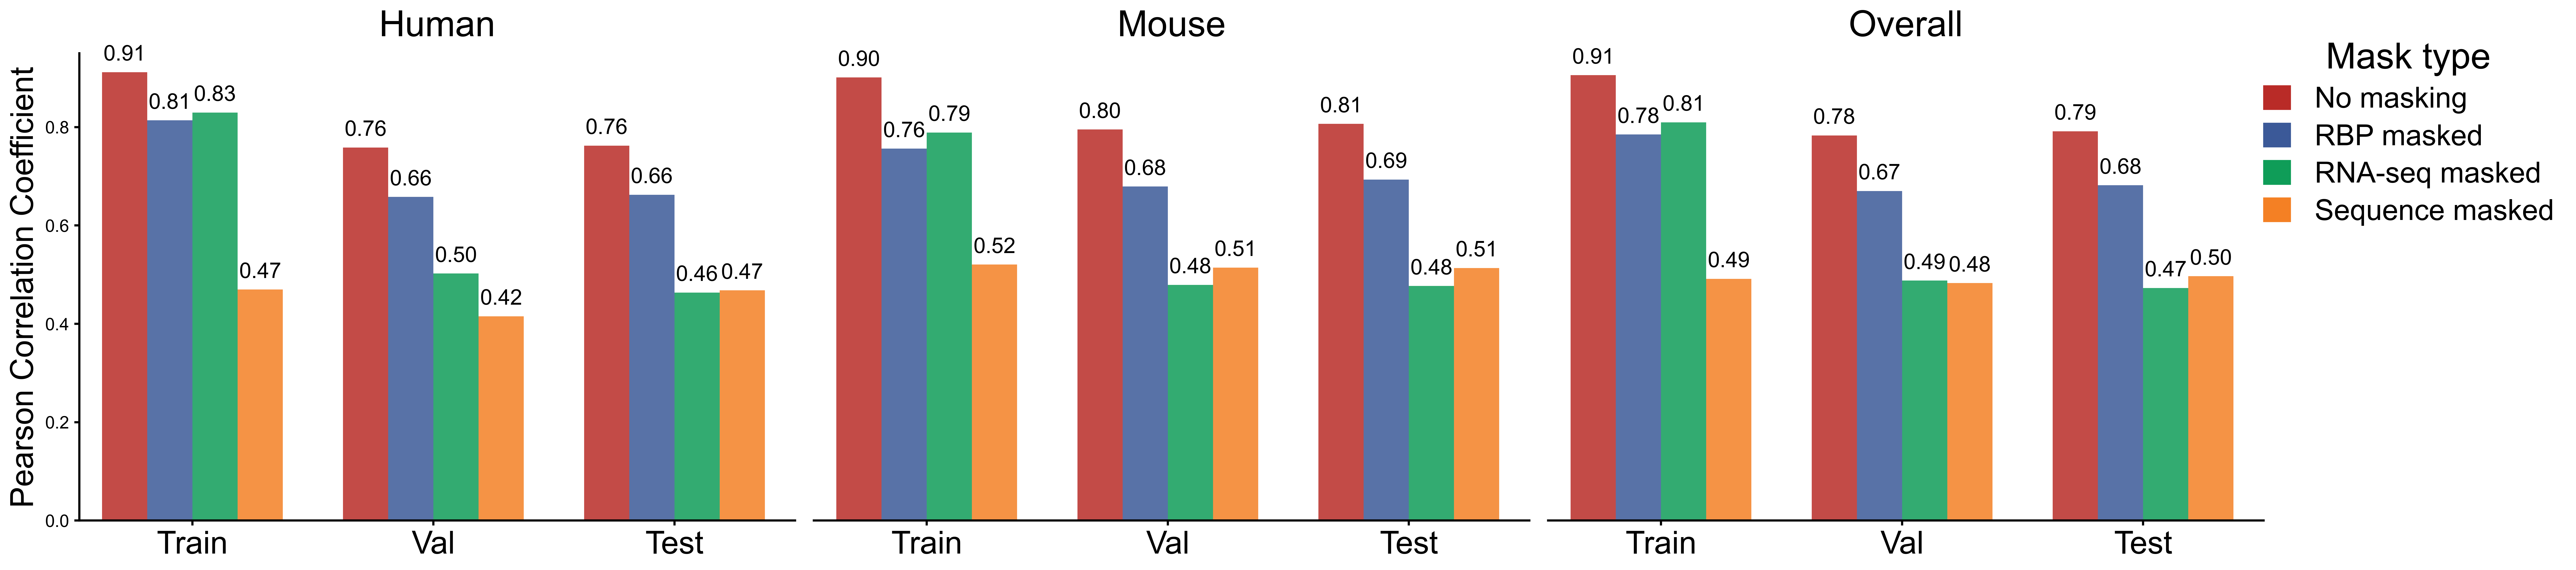

In [27]:
from matplotlib.patches import Patch
def plot_mask_pcc(
    plot_df,
    bar_width=0.4,
    group_pacing=0.3,
    bbox_to_anchor=(1.13, 0.87),
    figsize=(16,5), 
    dpi=500
):
    # dataframe preparation
    model_order = ['complete', 'maskrbp', 'maskrna', 'maskseq']
    phase_order = ['train', 'val', 'test']
    species_order = ['human', 'mouse', 'combined']
    model_labels = {
        'complete': 'No masking',
        'maskrna': 'RNA-seq masked',
        'maskseq': 'Sequence masked',
        'maskrbp': 'RBP masked'
    }
    species_labels = {
        'human': 'Human',
        'mouse': 'Mouse',
        'combined': 'Overall'
    }
    phase_labels = {
        'train': 'Train',
        'val': 'Val',
        'test': 'Test'
    }
    
    model_colors = {
        'complete': '#b92b27',   
        'maskseq': '#F48024',
        'maskrna': '#0f9d58',
        'maskrbp': '#3b5998'
    }
    
    n_phases = len(phase_order)
    n_models = len(model_order)
    
    # plotting
    fig, axes = plt.subplots(1, 3, figsize=figsize, dpi=dpi, sharey=True)
    plt.subplots_adjust(wspace=0.5)

    for ax_idx, species in enumerate(species_order):
        ax = axes[ax_idx]
        species_df = plot_df[plot_df['species'] == species]
        
        # Record positions and values
        all_positions, all_values, all_colors, phase_center = [], [], [], []
        
        for phase_idx, phase in enumerate(phase_order):
            group_start = phase_idx * (n_models * bar_width + group_pacing)
            phase_positions = []
            for model_idx, model in enumerate(model_order):
                pos = group_start + model_idx * bar_width
                phase_positions.append(pos)
                all_positions.append(pos)
                
                value = species_df[
                    (species_df['model_type'] == model) & 
                    (species_df['data_phase'] == phase)
                ]['global_pcc'].values[0]
                all_values.append(value)
                all_colors.append(model_colors[model])
            
            center = group_start + (n_models * bar_width) / 2 - bar_width / 2
            phase_center.append(center)
        
        bars = ax.bar(all_positions, all_values, color=all_colors, width=bar_width, edgecolor='black', linewidth=0.0, alpha=0.85)
        
        # label value
        for bar, val in zip(bars, all_values):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.015,
                f'{val:.2f}',
                ha='center', va='bottom', fontsize=15)
            
        ax.set_xticks(phase_center)
        ax.set_xticklabels([phase_labels[ph] for ph in phase_order], fontsize=22, fontweight='regular')
        ax.set_title(f"{species_labels[species]}", fontsize=25, fontweight='regular', pad=12)
        
        if ax_idx == 0:
            ax.set_ylabel('Pearson Correlation Coefficient', 
                            fontsize=22, fontweight='regular')
            
        ax.set_ylim(0, 0.95)
        ax.set_xlim(-0.3, phase_center[-1] + 0.8)
        ax.set_axisbelow(True)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        if ax_idx > 0:
            ax.spines['left'].set_visible(False)
            ax.yaxis.set_ticks_position('none')

    # Add legend
    legend_patches = [
    Patch(facecolor=model_colors[model], edgecolor='white', 
            linewidth=0.8, alpha=1, label=model_labels[model])
        for model in model_order
    ]
    
    fig.legend(handles=legend_patches, 
        loc='upper right',
        bbox_to_anchor=bbox_to_anchor,
        frameon=True, 
        fontsize=20,
        labelspacing=0.3,
        title="Mask type",
        title_fontsize=25,
        handlelength=1.0,
        handleheight=1.0, 
        edgecolor='white',
        fancybox=False,
        shadow=False)

    plt.tight_layout(rect=[0, 0, 1, 0.94])
    plt.show()
    
plot_mask_pcc(
    plot_pcc_df,
    bar_width=0.3,
    group_pacing=0.4,
    figsize=(22,6),
    dpi=500,
    bbox_to_anchor=(1.13, 0.9)
)

In [51]:
plot_dicts = []
for model_type in model_types:
    for phid, data_phase in enumerate(data_phases):
        metric = 'avg_loss'
        stats = summaries.get((model_type, data_phase))
        stat_dict = {}
        stat_dict['model_type'] = model_type
        stat_dict['species'] = "combined"
        stat_dict['data_phase'] = data_phase
        stat_dict[metric] = stats[metric]
        plot_dicts.append(stat_dict)
plot_loss_df = pd.DataFrame(plot_dicts)

In [52]:
plot_loss_df

,model_type,species,data_phase,avg_loss
0,complete,combined,train,0.016894
1,complete,combined,val,0.037490
2,complete,combined,test,0.031275
3,maskrna,combined,train,0.031163
4,maskrna,combined,val,0.074688
5,maskrna,combined,test,0.065731
6,maskseq,combined,train,0.088455
7,maskseq,combined,val,0.095178
8,maskseq,combined,test,0.082625
9,maskrbp,combined,train,0.036290


In [12]:
from matplotlib.patches import Patch
def plot_mask_loss(
    plot_df,
    bar_width=0.4,
    group_pacing=0.3,
    bbox_to_anchor=(1.13, 0.87),
    figsize=(16,5), 
    dpi=500
):
    # dataframe preparation
    model_order = ['complete', 'maskrbp', 'maskrna', 'maskseq']
    phase_order = ['train', 'val', 'test']
    species_order = ['combined']
    model_labels = {
        'complete': 'No masking',
        'maskrna': 'RNA-seq masked',
        'maskseq': 'Sequence masked',
        'maskrbp': 'RBP masked'
    }
    species_labels = {
        'human': 'Human',
        'mouse': 'Mouse',
        'combined': 'Overall'
    }
    phase_labels = {
        'train': 'Train',
        'val': 'Val',
        'test': 'Test'
    }
    
    model_colors = {
        'complete': '#b92b27',   
        'maskseq': '#F48024',
        'maskrna': '#0f9d58',
        'maskrbp': '#3b5998'
    }
    
    n_phases = len(phase_order)
    n_models = len(model_order)
    
    # plotting
    fig, ax = plt.subplots(1, len(species_order), figsize=figsize, dpi=dpi, sharey=True)
    plt.subplots_adjust(wspace=0.0)

    species = species_order[0]
    ax_idx = 0

    species_df = plot_df[plot_df['species'] == species]
    
    # Record positions and values
    all_positions, all_values, all_colors, phase_center = [], [], [], []
    
    for phase_idx, phase in enumerate(phase_order):
        group_start = phase_idx * (n_models * bar_width + group_pacing)
        phase_positions = []
        for model_idx, model in enumerate(model_order):
            pos = group_start + model_idx * bar_width
            phase_positions.append(pos)
            all_positions.append(pos)
            
            value = species_df[
                (species_df['model_type'] == model) & 
                (species_df['data_phase'] == phase)
            ]['avg_loss'].values[0]
            all_values.append(value)
            all_colors.append(model_colors[model])
        
        center = group_start + (n_models * bar_width) / 2 - bar_width / 2
        phase_center.append(center)
        
    bars = ax.bar(all_positions, all_values, color=all_colors, width=bar_width, edgecolor='black', linewidth=0.0, alpha=0.85)
    
    # label value
    for bar, val in zip(bars, all_values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:.3f}',
            ha='center', va='bottom', fontsize=10)
        
    ax.set_xticks(phase_center)
    ax.set_xticklabels([phase_labels[ph] for ph in phase_order], fontsize=12, fontweight='regular')
    ax.set_title(f"{species_labels[species]}", fontsize=12, fontweight='regular', pad=15)
    
    if ax_idx == 0:
        ax.set_ylabel('MSE Loss', 
                        fontsize=12, fontweight='regular')
        
    ax.set_ylim(0, 0.1)
    ax.set_xlim(-0.3, phase_center[-1] + 0.8)
    ax.set_axisbelow(True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    if ax_idx > 0:
        ax.spines['left'].set_visible(False)
        ax.yaxis.set_ticks_position('none')

    # Add legend
    legend_patches = [
    Patch(facecolor=model_colors[model], edgecolor='white', 
            linewidth=0.8, alpha=1, label=model_labels[model])
        for model in model_order
    ]
    
    fig.legend(handles=legend_patches, 
        loc='upper right',
        bbox_to_anchor=bbox_to_anchor,
        frameon=True, 
        fontsize=10,
        labelspacing=0.3,
        title="Mask type",
        title_fontsize=10,
        handlelength=1.0,
        handleheight=1.0, 
        edgecolor='white',
        fancybox=False,
        shadow=False)

    plt.tight_layout(rect=[0, 0, 1, 0.94])
    plt.show()
    
plot_mask_loss(
    plot_loss_df,
    bar_width=0.4,
    group_pacing=0.3,
    figsize=(6,4),
    dpi=500,
    bbox_to_anchor=(1.2, 0.87)
)

NameError: name 'plot_loss_df' is not defined

## 2. Plot species-specific model

In [104]:
model_types = ['complete', 'human', 'mouse']
data_phases = ['train', 'val', 'test']
species = ['human', 'mouse', 'combined']
metrics = ['avg_loss', 'global_pcc']

plot_dicts = []
for model_type in model_types:
    for data_phase in data_phases:
        for sidx, specie in enumerate(species):
            metric = 'global_pcc'
            stats = summaries.get((model_type, data_phase))
            stat_dict = {}
            stat_dict['model_type'] = model_type
            stat_dict['data_phase'] = data_phase
            stat_dict['species'] = specie
            stat_dict[metric] = stats[metric][sidx]
            plot_dicts.append(stat_dict)
plot_pcc_df = pd.DataFrame(plot_dicts)

In [90]:
# drop row with global_pcc 0.0
plot_pcc_df = plot_pcc_df[plot_pcc_df['global_pcc'] != 0.0].reset_index(drop=True)
plot_pcc_df

,model_type,data_phase,species,global_pcc
0,complete,train,human,0.911688
1,complete,train,mouse,0.900953
2,complete,train,combined,0.905556
3,complete,val,human,0.758535
4,complete,val,mouse,0.795246
5,complete,val,combined,0.783139
6,complete,test,human,0.762289
7,complete,test,mouse,0.806669
8,complete,test,combined,0.791573
9,human,train,human,0.898998


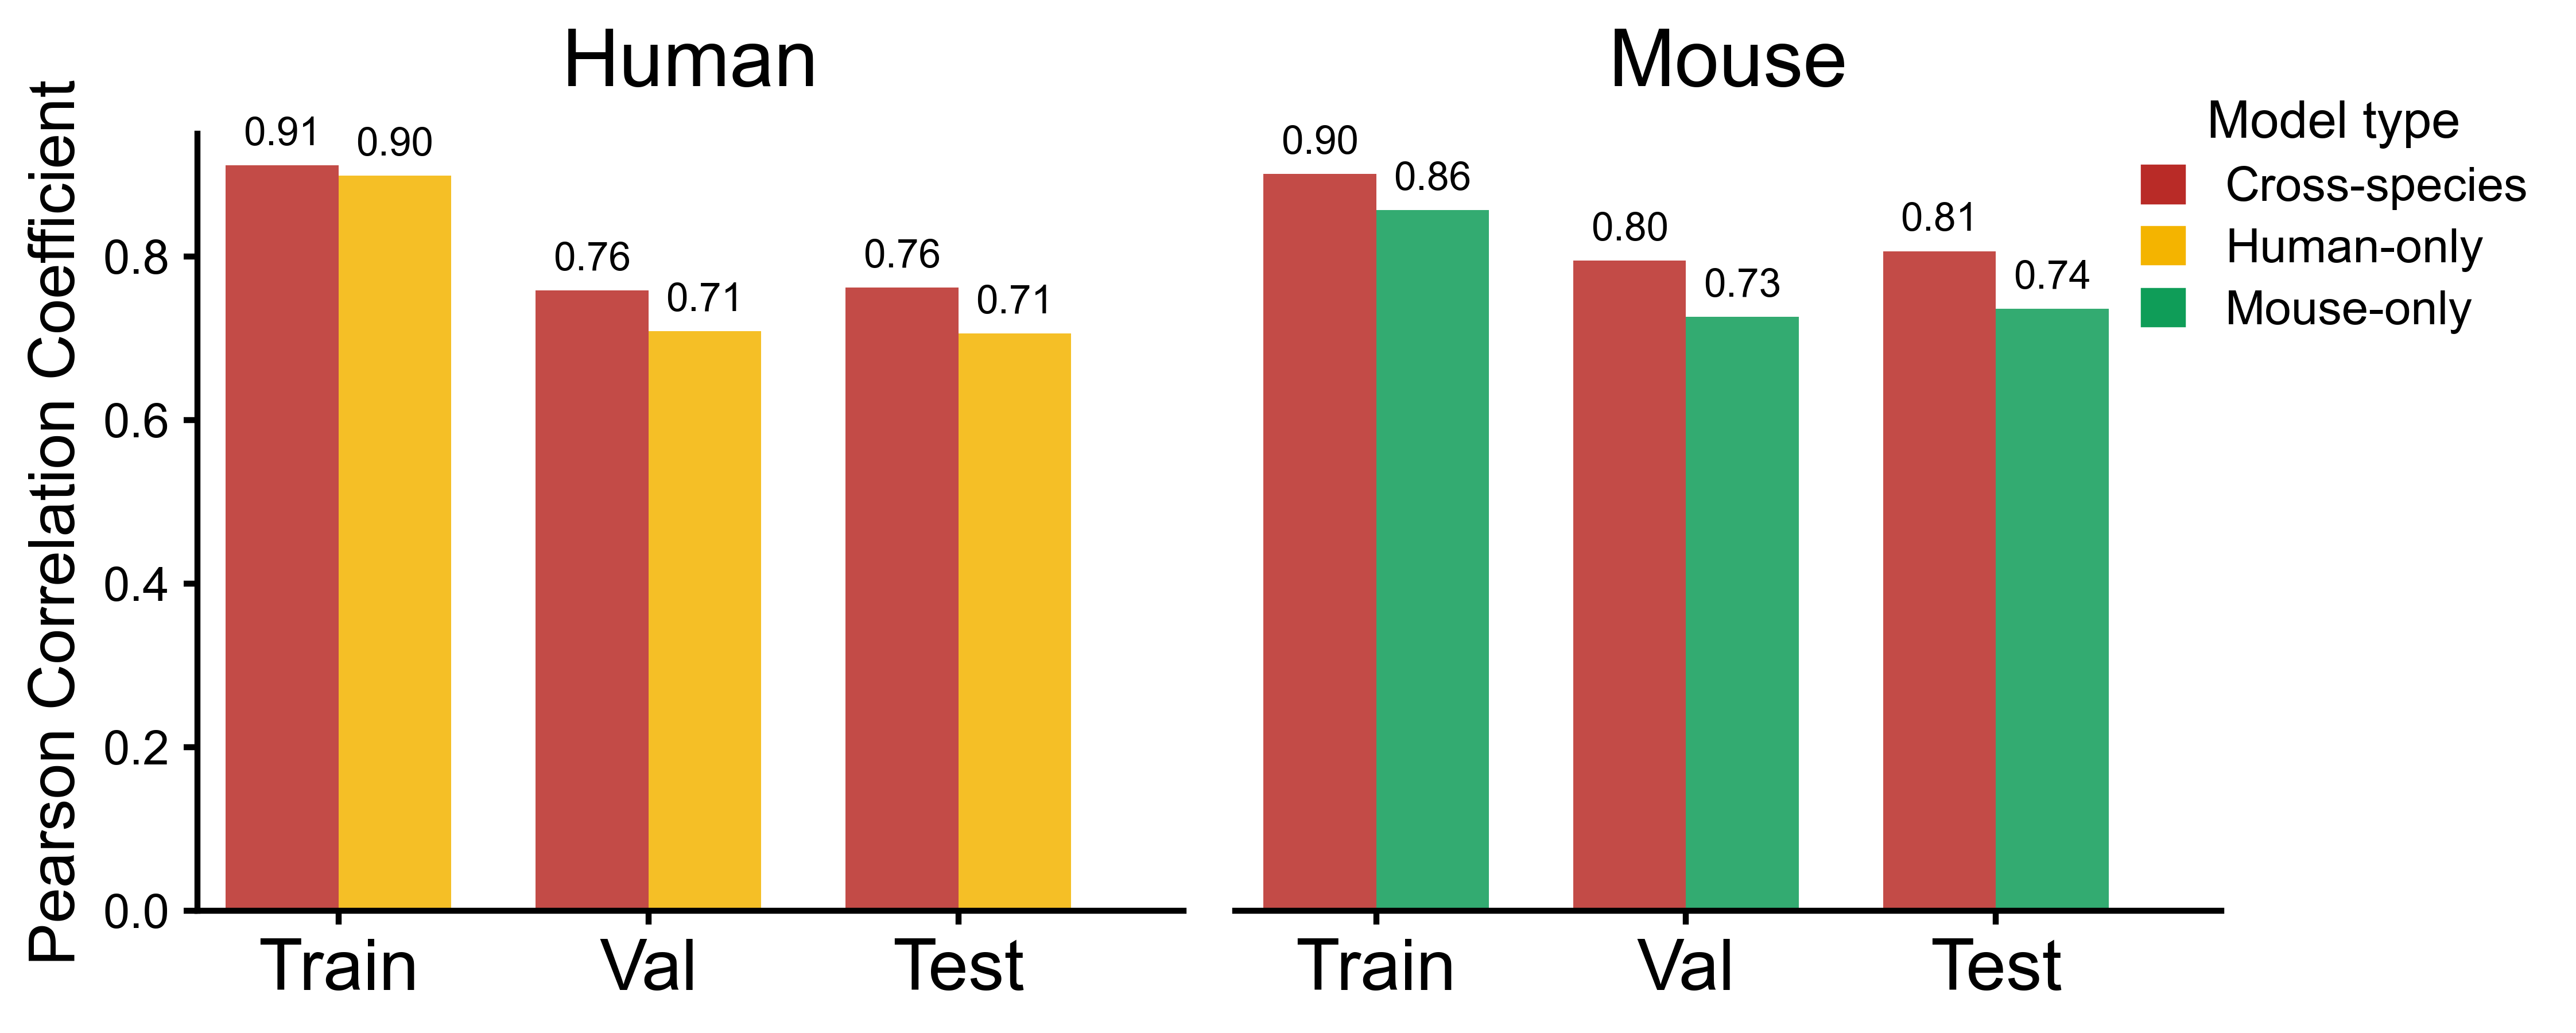

In [101]:
from matplotlib.patches import Patch
def plot_species_pcc(
    plot_df,
    bar_width=0.4,
    group_pacing=0.3,
    bbox_to_anchor=(1.13, 0.87),
    figsize=(16,5), 
    dpi=500
):
    # dataframe preparation
    model_order = ['complete', 'human', 'mouse']
    phase_order = ['train', 'val', 'test']
    species_order = ['human', 'mouse']
    model_labels = {
        'complete': 'Cross-species',
        'human': 'Human-only',
        'mouse': 'Mouse-only'
    }
    species_labels = {
        'human': 'Human',
        'mouse': 'Mouse'
    }
    phase_labels = {
        'train': 'Train',
        'val': 'Val',
        'test': 'Test'
    }
    
    model_colors = {
        'complete': '#b92b27',   
        'human': '#f4b400', 
        'mouse': '#0f9d58'
    }
    
    model_map = {
        'human': ['complete', 'human'],
        'mouse': ['complete', 'mouse']
    }
    
    n_phases = len(phase_order)
    n_models = 2
    
    # plotting
    fig, axes = plt.subplots(1, len(species_order), figsize=figsize, dpi=dpi, sharey=True)
    plt.subplots_adjust(wspace=0.0)

    for ax_idx, species in enumerate(species_order):
        ax = axes[ax_idx]
        species_df = plot_df[plot_df['species'] == species].copy()
        models_for_species = model_map[species]
        # Record positions and values
        all_positions, all_values, all_colors, phase_center = [], [], [], []
        
        for phase_idx, phase in enumerate(phase_order):
            group_start = phase_idx * (n_models * bar_width + group_pacing)
            phase_positions = []
            for model_idx, model in enumerate(models_for_species):
                pos = group_start + model_idx * bar_width
                phase_positions.append(pos)
                all_positions.append(pos)
                
                value = species_df[
                    (species_df['model_type'] == model) & 
                    (species_df['data_phase'] == phase)
                ]['global_pcc'].values[0]
                all_values.append(value)
                all_colors.append(model_colors[model])
            
            center = group_start + (n_models * bar_width) / 2 - bar_width / 2
            phase_center.append(center)
        
        bars = ax.bar(all_positions, all_values, color=all_colors, width=bar_width, edgecolor='black', linewidth=0.0, alpha=0.85)
        
        # label value
        for bar, val in zip(bars, all_values):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.015,
                f'{val:.2f}',
                ha='center', va='bottom', fontsize=10)
            
        ax.set_xticks(phase_center)
        ax.set_xticklabels([phase_labels[ph] for ph in phase_order], fontsize=18, fontweight='regular')
        ax.set_title(f"{species_labels[species]}", fontsize=20, fontweight='regular', pad=12)
        
        if ax_idx == 0:
            ax.set_ylabel('Pearson Correlation Coefficient', 
                            fontsize=16, fontweight='regular')
            
        ax.set_ylim(0, 0.95)
        ax.set_xlim(-0.3, phase_center[-1] + 0.8)
        ax.set_axisbelow(True)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        if ax_idx > 0:
            ax.spines['left'].set_visible(False)
            ax.yaxis.set_ticks_position('none')

    # Add legend
    legend_patches = [
    Patch(facecolor=model_colors[model], edgecolor='white', 
            linewidth=0.8, alpha=1, label=model_labels[model])
        for model in model_order
    ]
    
    fig.legend(handles=legend_patches, 
        loc='upper right',
        bbox_to_anchor=bbox_to_anchor,
        frameon=True, 
        fontsize=12,
        labelspacing=0.3,
        title="Model type",
        title_fontsize=13,
        handlelength=1.0,
        handleheight=1.0, 
        edgecolor='white',
        fancybox=False,
        shadow=False)

    plt.tight_layout(rect=[0, 0, 1, 0.94])
    plt.show()
    
plot_species_pcc(
    plot_pcc_df,
    group_pacing=0.3,
    figsize=(8,4),
    dpi=500,
    bbox_to_anchor=(1.13, 0.87)
)

In [107]:
# model_types = ['complete', 'human', 'mouse']
# data_phases = ['train', 'val', 'test']
# species = ['human', 'mouse', 'combined']
# metrics = ['avg_loss', 'global_pcc']

# plot_dicts = []
# for model_type in model_types:
#     for phid, data_phase in enumerate(data_phases):
#         for sidx, specie in enumerate(species):
#             metric = 'avg_loss'
#             stats = summaries.get((model_type, data_phase))
#             stat_dict = {}
#             stat_dict['model_type'] = model_type
#             stat_dict['species'] = "combined"
#             stat_dict['data_phase'] = data_phase
#             stat_dict[metric] = stats[metric]
#             plot_dicts.append(stat_dict)
#     plot_loss_df = pd.DataFrame(plot_dicts)

## 3. Heatmap

In [28]:
!ls {benchmark_dir}

allfold_sample_level_pcc_matrix.csv	benchmark_species_summaries.pkl
allfold_sample_level_pcc_matrix_v2.csv	predicted_bigwig
benchmark_maskdata_summaries.pkl


In [33]:
entry_df = pd.read_csv(os.path.join(benchmark_dir, "allfold_sample_level_pcc_matrix.csv"))
pcc_df = entry_df.pivot(
    index='SID_obs', 
    columns='SID_pred', 
    values='PCC'
).astype(float)

In [34]:
new_colnames = [name.split("-1")[0] for name in pcc_df.columns]
new_rownames = [name.split("-1")[0] for name in pcc_df.index]
pcc_df.columns = new_colnames
pcc_df.index = new_rownames

In [35]:
from scipy.cluster.hierarchy import linkage, leaves_list

Z = linkage(pcc_df, method='ward')
row_order = leaves_list(Z)
pcc_df = pcc_df.iloc[row_order, row_order]

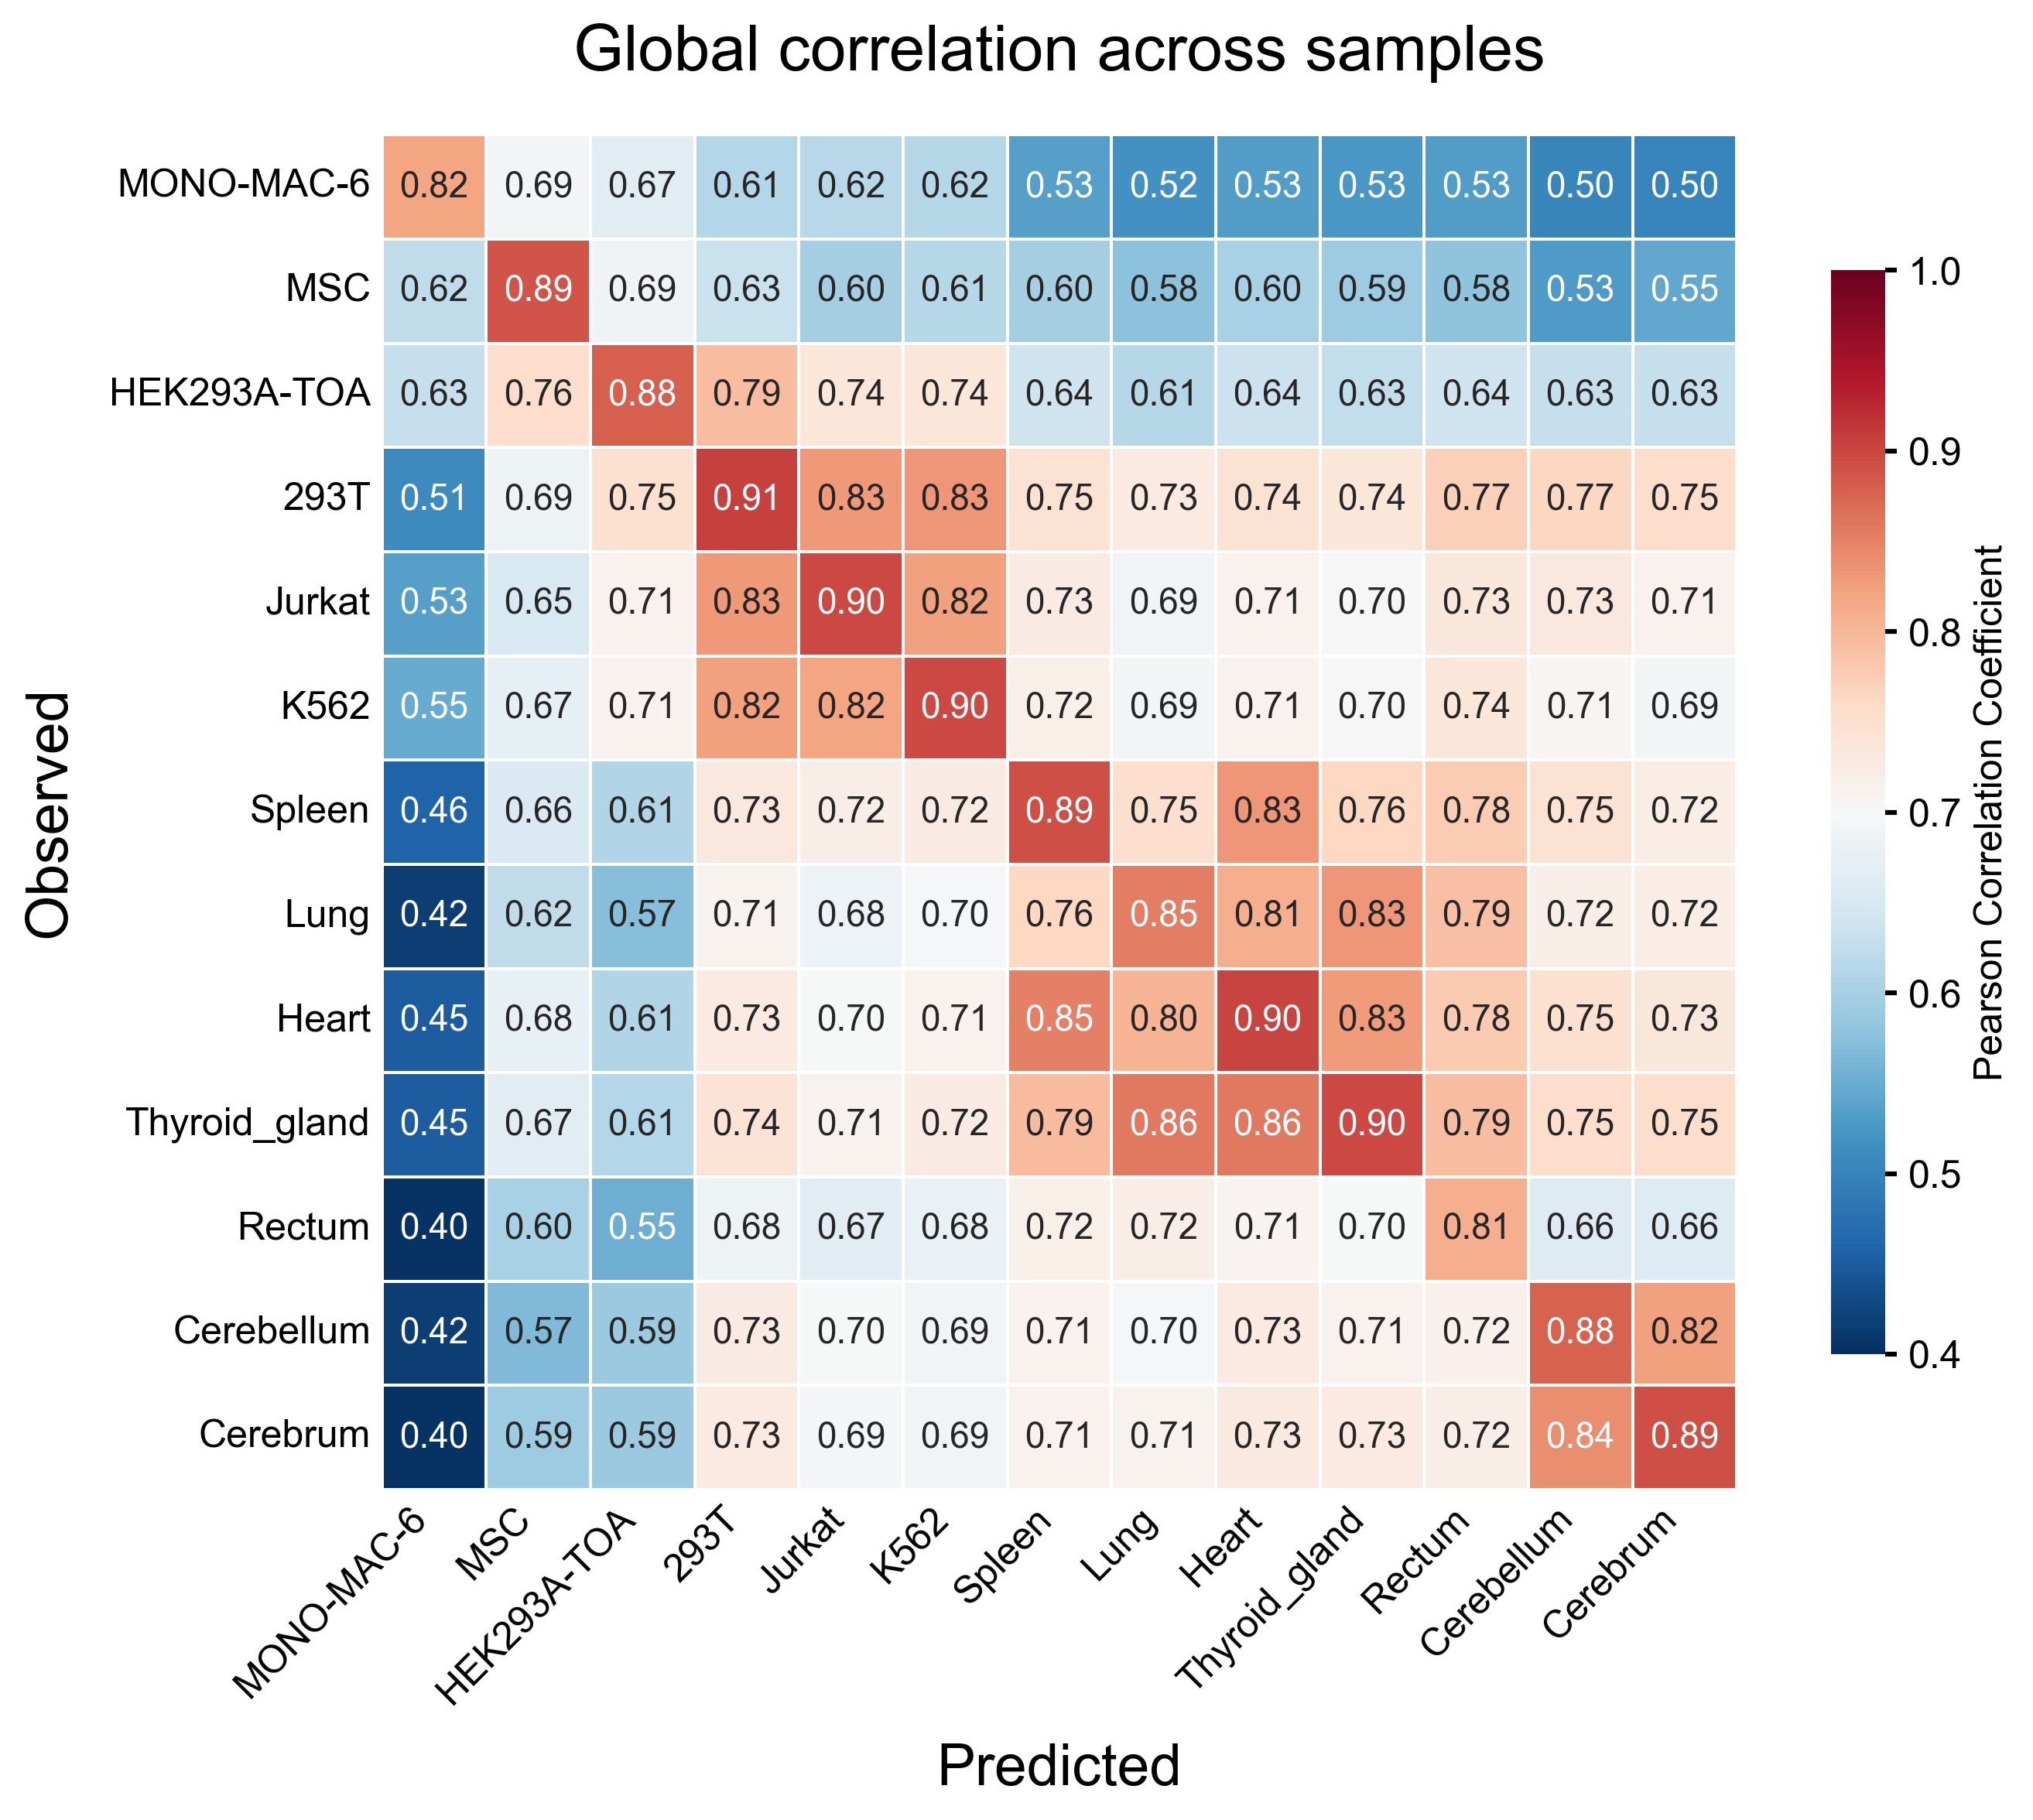

In [36]:
from matplotlib.colors import LinearSegmentedColormap

fig, ax = plt.subplots(figsize=(10, 8), dpi=300)

matrix_size = max(pcc_df.shape)
#cmap = sns.diverging_palette(240, 10, as_cmap=True)
colors_nature = ['#053061', '#2166AC', '#4393C3', '#92C5DE', '#D1E5F0',
                 '#F7F7F7',
                 '#FDDBC7', '#F4A582', '#D6604D', '#B2182B', '#6C001F']
cmap = LinearSegmentedColormap.from_list('nature', colors_nature)

mask = pcc_df.isnull()
heatmap = sns.heatmap(
    pcc_df, 
    annot=True,  
    fmt=".2f",   
    cmap=cmap,   
    vmin=0.4,    
    vmax=1.0,    
    mask=mask,
    linewidths=0.5,
    linecolor='white',
    square=True, 
    cbar_kws={
        'label': 'Pearson Correlation Coefficient',
        'shrink': 0.8,
        'aspect': 20,
        'pad': 0.05
    },
    annot_kws={
        'size': 11,           
        'weight': 'normal',
        #'color': 'black'
    },
    ax=ax
)
cbar = heatmap.collections[0].colorbar
cbar.set_label('Pearson Correlation Coefficient', fontsize=12, fontweight='normal')

plt.title('Global correlation across samples', fontsize=20, fontweight='regular', pad=20)
plt.ylabel('Observed', fontsize=18, fontweight='normal', labelpad=10)
plt.xlabel('Predicted', fontsize=18, fontweight='normal', labelpad=10)

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0, ha='right')


ax.tick_params(axis='both', which='both', length=0)

ax.grid(which="minor", color="white", linestyle='-', linewidth=2)
plt.tight_layout()
#plt.savefig("/home/wangrr/Analysis/epiRNA/src/notebook/benchmark/test.pdf", dpi=300, bbox_inches='tight', facecolor='white')
plt.show()